# Detection Summary Engine
* Use a pretrained object detection model (e.g., YOLOv5, Faster R-CNN)
* Process every 5th frame of a 15–20 second .mp4 video
* Output per-frame JSON with:
    - Class Labels 
    - Bounding Box coordinates 
    - Confidence scores
* Identify the frame with maximum class diversity
* Visualize object frequency using a bar chart
* (Optional) Save annotated frames or a compiled output video

In [1]:
#importing necessary libraries
import cv2
import torch
from ultralytics import YOLO
import json
from collections import defaultdict
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [9]:
#function to process every 5th frame of the video
def process_video(video_path, model_name='yolov8n.pt', frame_skip=5):
    
    model = YOLO(model_name)
    cap = cv2.VideoCapture(video_path)

    if not cap.isOpened(): #to check if video path is correct or not
        print(f"Error: Could not open video {video_path}")
        return [], {}, -1

    # get frame data
    frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps = cap.get(cv2.CAP_PROP_FPS)
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

    #create necessary variables like object count, frame count etc.
    per_frame_data = []
    total_object_counts = defaultdict(int)
    max_diversity = -1
    frame_with_max_diversity = -1
    frame_count = 0

    while True:
        ret, frame = cap.read()
        if not ret:
            break

        if frame_count % frame_skip == 0:
            print(f"Processing frame {frame_count}")
            results = model(frame) 

            frame_json = {
                "frame_number": frame_count,
                "detections": []
            }
            current_frame_classes = set()

            for r in results:
                boxes = r.boxes # Boxes object
                names = model.names # Class names

                for i, box in enumerate(boxes):
                    x1, y1, x2, y2 = map(int, box.xyxy[0])
                    confidence = float(box.conf[0])
                    class_id = int(box.cls[0])
                    class_label = names[class_id]

                    detection_info = {
                        "class_label": class_label,
                        "bounding_box": [x1, y1, x2, y2], # [x_min, y_min, x_max, y_max]
                        "confidence": confidence
                    }
                    frame_json["detections"].append(detection_info)
                    total_object_counts[class_label] += 1
                    current_frame_classes.add(class_label)

            per_frame_data.append(frame_json)

            # Check for maximum class diversity
            diversity = len(current_frame_classes)
            if diversity > max_diversity:
                max_diversity = diversity
                frame_with_max_diversity = frame_count

        frame_count += 1

    cap.release()
    return per_frame_data, total_object_counts, frame_with_max_diversity

In [10]:
video_input_path='input video/video-1.mp4'  #input video path
print(f"Starting video processing for: {video_input_path}")
per_frame_json_output, total_object_counts, frame_with_max_diversity = process_video(video_input_path, model_name='yolov8n.pt', frame_skip=5)


Starting video processing for: input video/video-1.mp4
Processing frame 0

0: 384x640 20 cars, 2 trucks, 124.3ms
Speed: 3.0ms preprocess, 124.3ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)
Processing frame 5

0: 384x640 20 cars, 2 trucks, 1 boat, 56.8ms
Speed: 7.0ms preprocess, 56.8ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)
Processing frame 10

0: 384x640 1 person, 19 cars, 1 truck, 1 boat, 50.3ms
Speed: 2.2ms preprocess, 50.3ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)
Processing frame 15

0: 384x640 20 cars, 1 truck, 1 boat, 68.8ms
Speed: 2.1ms preprocess, 68.8ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)
Processing frame 20

0: 384x640 20 cars, 1 truck, 1 boat, 49.3ms
Speed: 2.2ms preprocess, 49.3ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)
Processing frame 25

0: 384x640 19 cars, 2 trucks, 1 boat, 50.1ms
Speed: 2.0ms preprocess, 50.1ms inference, 0.9ms postprocess per 

### Detection Summary

In [11]:
# 1. Save Per-frame JSON
if per_frame_json_output:
    with open("detection_summary.json", "w") as f:
        json.dump(per_frame_json_output, f, indent=4)
        print("Per-frame JSON summary saved to detection_summary.json")
else:
    print("No detections to save in JSON.")

Per-frame JSON summary saved to detection_summary.json


In [12]:
# 2. Count Total objects per Class
print("Total Objects per Class:")
if total_object_counts:
    for class_label, count in total_object_counts.items():
        print(f"- {class_label}: {count}")
else:
    print("No objects detected.")

Total Objects per Class:
- car: 6232
- truck: 632
- boat: 119
- person: 15
- fire hydrant: 7


In [13]:
# 3. Identify Frame with Maximum Class Diversity
print(f"Frame with Maximum Class Diversity: Frame {frame_with_max_diversity}")
if frame_with_max_diversity != -1:
    for frame_data in per_frame_json_output:
        if frame_data["frame_number"] == frame_with_max_diversity:
            diverse_classes = set(d["class_label"] for d in frame_data["detections"])
            print(f"Unique classes in this frame: {len(diverse_classes)} -> {list(diverse_classes)}")
            break
else:
    print("No frame with maximum diversity identified (perhaps no detections).")

Frame with Maximum Class Diversity: Frame 10
Unique classes in this frame: 4 -> ['truck', 'boat', 'car', 'person']


In [14]:
#Visualize Object freqeuncy using a Bar Chart
def visualize_object_frequency(total_object_counts):
    if not total_object_counts:
        print("No objects detected for visualization.")
        return

    class_labels = list(total_object_counts.keys())
    counts = list(total_object_counts.values())

    plt.figure(figsize=(15, 5))
    plt.bar(class_labels, counts, color='#C1EDFF')
    plt.xlabel('Class Label')
    plt.ylabel('Total Count')
    plt.title('Object Frequency Per Class')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

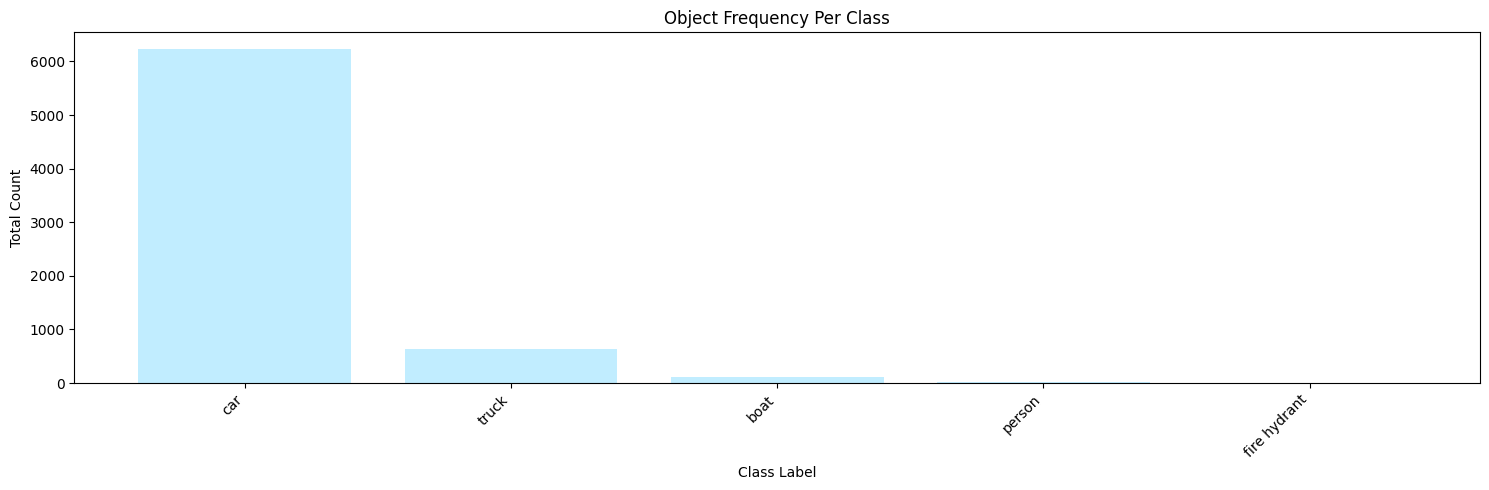

In [15]:
# 4. Visualize Object Frequency
if total_object_counts:
    visualize_object_frequency(total_object_counts)
else:
    print("Skipping object frequency visualization as no objects were detected.")